In [ ]:
# pip install underthesea

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from joblib import dump
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")



In [ ]:
drive.mount('/drive')
path = '/drive/MyDrive/Colab Notebooks/Data/Data_train.xlsx'
outputPath = '/drive/MyDrive/Colab Notebooks/Data/'

df = pd.read_excel(path)

print(df);

Mounted at /drive
                                                  WORDS  Label
0                                         Kỳ tính thuế:      5
1                                              Lần đầu:      1
2                                      Bổ sung lần thứ:      0
3                                       Người nộp thuế:      0
4                                           Mã số thuế:      0
...                                                 ...    ...
2273                                        1819 - GVCN      0
2274                                      1819 - GVCN.1      0
2275                                  1819 - Điện thoại      0
2276  1819 - Email cá nhân thường dùng (ngoài e-mail...      0
2277                                    1819 - Email SV      0

[2278 rows x 2 columns]


In [ ]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=7000)
tfidf_vect_ngram.fit(df['WORDS'])

tranforms_tfidf_data = tfidf_vect_ngram.transform(df['WORDS'])
dump(tfidf_vect_ngram, outputPath + 'tfidf_vect_ngram.pkl')


k_fold = KFold(n_splits=10, shuffle=True, random_state=42)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

[[ 0.19615921  0.082613   -0.29668713 ...  0.60694754  0.43884143
  -0.39085722]
 [-0.23727721  0.09135211 -0.75514627 ...  0.32960877  0.52700585
  -0.35708687]
 [-0.04541507  0.04725078 -0.4266688  ...  0.29786974  0.492901
  -0.40854934]
 ...
 [-0.09172543 -0.3975445  -0.56186646 ... -0.05574156  0.24739748
   0.10380226]
 [ 0.3739464  -0.05210372 -0.6149432  ...  0.18931752  0.39631137
  -0.37191534]
 [ 0.10489304  0.37717408 -0.5409795  ...  0.04556447 -0.2640356
  -0.1855364 ]]
[0 0 0 ... 6 4 2]
Train scores: [0.9780487804878049, 0.9795121951219512, 0.9760975609756097, 0.9785365853658536, 0.9760975609756097, 0.975609756097561, 0.9770731707317073, 0.9770731707317073, 0.9761092150170648, 0.9765967820575329]
Mean train accuracy: 0.9770754777562403
Validation scores: [0.8903508771929824, 0.8728070175438597, 0.8508771929824561, 0.9210526315789473, 0.8947368421052632, 0.8771929824561403, 0.9122807017543859, 0.8859649122807017, 0.8898678414096917, 0.8722466960352423]
Mean validation acc

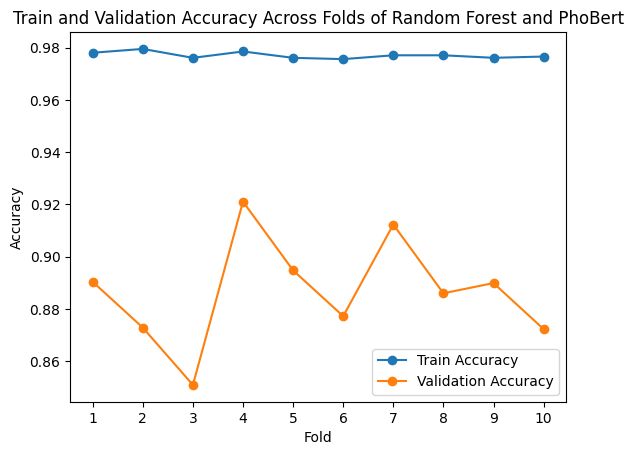

In [ ]:
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import cross_val_score

import torch
from torch.utils.data import Dataset, DataLoader


# Define the dataset class using PhoBERT tokenizer
class PhoBertDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['WORDS']
        label = self.df.iloc[idx]['Label']
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove the batch dimension
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize PhoBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModel.from_pretrained("vinai/phobert-base")

# Create the PhoBERT dataset
dataset = PhoBertDataset(df, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Function to get embeddings from PhoBERT
def get_embeddings(dataloader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            label = batch['labels']
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_states = output.last_hidden_state[:, 0, :]
            embeddings.append(last_hidden_states.cpu().numpy())
            labels.append(label.cpu().numpy())
    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

# Get embeddings
embeddings, labels = get_embeddings(dataloader)

print(embeddings)
print(labels)

# Train Random Forest with K-Fold cross-validation
rf_withPhoBert = RandomForestClassifier(n_estimators=100, random_state=42)

train_scores = []
val_scores = []

max_accuracy = 0
max_accuracy_model = None

for train_index, val_index in k_fold.split(df['WORDS']):
  X_train, X_val = embeddings[train_index], embeddings[val_index]
  y_train, y_val = labels[train_index], labels[val_index]
  rf_withPhoBert.fit(X_train, y_train)

  train_pred = rf_withPhoBert.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_pred)
  train_scores.append(train_accuracy)

  # Calculate accuracy on the validation set
  val_pred = rf_withPhoBert.predict(X_val)
  val_accuracy = accuracy_score(y_val, val_pred)
  val_scores.append(val_accuracy)

  if val_accuracy > max_accuracy:
    max_accuracy = val_accuracy
    max_accuracy_model = rf_withPhoBert

# # Print out the mean cross-validation score
# print(f"Mean CV Score: {np.mean(cv_scores)}")

print("Train scores:", train_scores)
print("Mean train accuracy:", sum(train_scores) / len(train_scores))
print("Validation scores:", val_scores)
print("Mean validation accuracy:", sum(val_scores) / len(val_scores))
print(f"Max accuracy: {max_accuracy}")
dump(rf_withPhoBert, outputPath + 'RandomForestWithPhoBert.pkl')

plt.plot(np.arange(1, 11), train_scores, label='Train Accuracy', marker='o')
plt.plot(np.arange(1, 11), val_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Across Folds of Random Forest and PhoBert')
plt.xticks(np.arange(1, 11))
plt.legend()
plt.show()




In [ ]:
print(embeddings)
print(labels)

[[ 0.19615921  0.082613   -0.29668713 ...  0.60694754  0.43884143
  -0.39085722]
 [-0.23727721  0.09135211 -0.75514627 ...  0.32960877  0.52700585
  -0.35708687]
 [-0.04541507  0.04725078 -0.4266688  ...  0.29786974  0.492901
  -0.40854934]
 ...
 [-0.09172543 -0.3975445  -0.56186646 ... -0.05574156  0.24739748
   0.10380226]
 [ 0.3739464  -0.05210372 -0.6149432  ...  0.18931752  0.39631137
  -0.37191534]
 [ 0.10489304  0.37717408 -0.5409795  ...  0.04556447 -0.2640356
  -0.1855364 ]]
[0 0 0 ... 6 4 2]


Train scores: [0.9482926829268292, 0.9492682926829268, 0.9497560975609756, 0.948780487804878, 0.9507317073170731, 0.9497560975609756, 0.9507317073170731, 0.9473170731707317, 0.9497805948317893, 0.9507557289127255]
Mean train accuracy: 0.9495170470085977
Validation scores: [0.8377192982456141, 0.8771929824561403, 0.8771929824561403, 0.9122807017543859, 0.8640350877192983, 0.8903508771929824, 0.8947368421052632, 0.9210526315789473, 0.8722466960352423, 0.8766519823788547]
Mean validation accuracy: 0.8823460081922869
Max accuracy: 0.9210526315789473


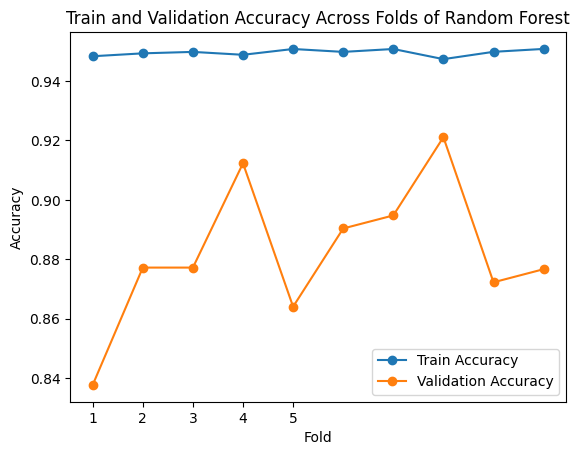

In [ ]:
## Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

train_scores = []
val_scores = []

max_accuracy = 0
max_accuracy_model = None

for train_index, val_index in k_fold.split(df['WORDS']):
  X_train, X_val = tranforms_tfidf_data[train_index], tranforms_tfidf_data[val_index]
  y_train, y_val = df['Label'][train_index], df['Label'][val_index]
  rf.fit(X_train, y_train)

  train_pred = rf.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_pred)
  train_scores.append(train_accuracy)

  # Calculate accuracy on the validation set
  val_pred = rf.predict(X_val)
  val_accuracy = accuracy_score(y_val, val_pred)
  val_scores.append(val_accuracy)

  if val_accuracy > max_accuracy:
    max_accuracy = val_accuracy
    max_accuracy_model = rf


print("Train scores:", train_scores)
print("Mean train accuracy:", sum(train_scores) / len(train_scores))
print("Validation scores:", val_scores)
print("Mean validation accuracy:", sum(val_scores) / len(val_scores))
print(f"Max accuracy: {max_accuracy}")
dump(rf, outputPath + 'RandomForest.pkl')

plt.plot(np.arange(1, 11), train_scores, label='Train Accuracy', marker='o')
plt.plot(np.arange(1, 11), val_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Across Folds of Random Forest')
plt.xticks(np.arange(1, 6))
plt.legend()
plt.show()

Train scores: [0.8731707317073171, 0.871219512195122, 0.8717073170731707, 0.8658536585365854, 0.8775609756097561, 0.8663414634146341, 0.8692682926829268, 0.8707317073170732, 0.8727450024378351, 0.8732325694783033]
Mean train accuracy: 0.8711831230452723
Validation scores: [0.8157894736842105, 0.8377192982456141, 0.8377192982456141, 0.8421052631578947, 0.8157894736842105, 0.8289473684210527, 0.8464912280701754, 0.8333333333333334, 0.8502202643171806, 0.8414096916299559]
Mean validation accuracy: 0.8349524692789242
Max accuracy 0.8502202643171806


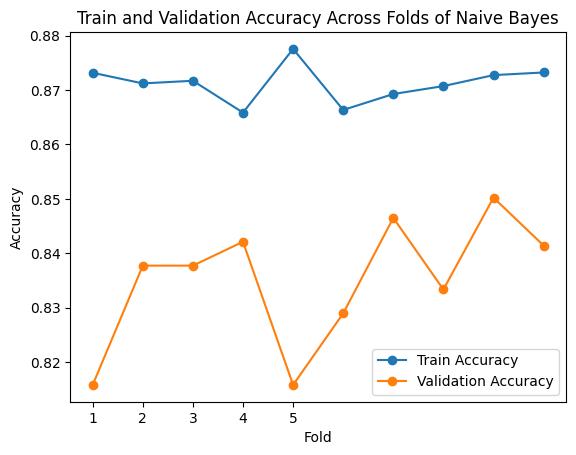

In [ ]:
## Naive Bayes

nb_classifier = MultinomialNB()

tranforms_tfidf_data_dense = tranforms_tfidf_data.toarray()

train_scores = []
val_scores = []

max_accuracy = 0
max_accuracy_model = None

for train_index, val_index in k_fold.split(df['WORDS']):
  X_train, X_val = tranforms_tfidf_data_dense[train_index], tranforms_tfidf_data_dense[val_index]
  y_train, y_val = df['Label'][train_index], df['Label'][val_index]

  nb_classifier.fit(X_train, y_train)

  train_pred = nb_classifier.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_pred)
  train_scores.append(train_accuracy)

  # Calculate accuracy on the validation set
  val_pred = nb_classifier.predict(X_val)
  val_accuracy = accuracy_score(y_val, val_pred)
  val_scores.append(val_accuracy)

  if val_accuracy > max_accuracy:
    max_accuracy = val_accuracy
    max_accuracy_model = nb_classifier

print("Train scores:", train_scores)
print("Mean train accuracy:", sum(train_scores) / len(train_scores))
print("Validation scores:", val_scores)
print("Mean validation accuracy:", sum(val_scores) / len(val_scores))
print(f"Max accuracy {max_accuracy}")
dump(nb_classifier, outputPath + 'NaiveBayes.pkl')


plt.plot(np.arange(1, 11), train_scores, label='Train Accuracy', marker='o')
plt.plot(np.arange(1, 11), val_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Across Folds of Naive Bayes')
plt.xticks(np.arange(1, 6))
plt.legend()
plt.show()

Train scores: [0.9380487804878048, 0.937560975609756, 0.94, 0.937560975609756, 0.94, 0.9390243902439024, 0.9395121951219512, 0.9360975609756098, 0.9380789858605558, 0.9414919551438323]
Mean train accuracy: 0.9387375819053169
Validation scores: [0.8464912280701754, 0.8771929824561403, 0.8728070175438597, 0.9035087719298246, 0.868421052631579, 0.8728070175438597, 0.8903508771929824, 0.8903508771929824, 0.8546255506607929, 0.8546255506607929]
Mean validation accuracy: 0.873118092588299
Max accuracy 0.9035087719298246


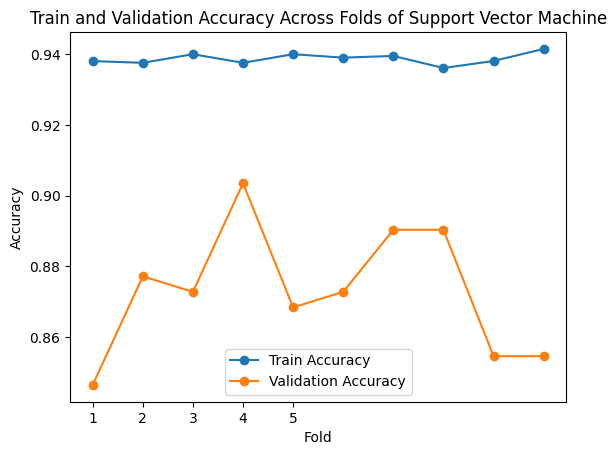

In [ ]:
## Suppor Vector Machine

svm_classifier = SVC(kernel='linear', random_state=42)

train_scores = []
val_scores = []

max_accuracy = 0
max_accuracy_model = None

for train_index, val_index in k_fold.split(df['WORDS']):
  X_train, X_val = tranforms_tfidf_data[train_index], tranforms_tfidf_data[val_index]
  y_train, y_val = df['Label'][train_index], df['Label'][val_index]

  svm_classifier.fit(X_train, y_train)

  train_pred = svm_classifier.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_pred)
  train_scores.append(train_accuracy)

  # Calculate accuracy on the validation set
  val_pred = svm_classifier.predict(X_val)
  val_accuracy = accuracy_score(y_val, val_pred)
  val_scores.append(val_accuracy)

  if val_accuracy > max_accuracy:
    max_accuracy = val_accuracy
    max_accuracy_model = svm_classifier

print("Train scores:", train_scores)
print("Mean train accuracy:", sum(train_scores) / len(train_scores))
print("Validation scores:", val_scores)
print("Mean validation accuracy:", sum(val_scores) / len(val_scores))

print(f"Max accuracy {max_accuracy}")
dump(svm_classifier, outputPath + 'SVM.pkl')

plt.plot(np.arange(1, 11), train_scores, label='Train Accuracy', marker='o')
plt.plot(np.arange(1, 11), val_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Across Folds of Support Vector Machine')
plt.xticks(np.arange(1, 6))
plt.legend()
plt.show()